## META TGI

In [ ]:
!pip install -U sagemaker transformers sentencepiece
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu

In [ ]:
%pip install --upgrade --quiet sagemaker

In [62]:
import os
import time
from sagemaker.huggingface import get_huggingface_llm_image_uri
import boto3
import json
from sagemaker.huggingface import HuggingFaceModel
import argparse
import yaml
import sagemaker
import pandas as pd
import json
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained('meta-llama/Llama-2-7b-chat-hf')

In [5]:
model_id = "meta-textgeneration-llama-2-70b-f"
model_version = "3.*"

In [ ]:
from sagemaker.jumpstart.model import JumpStartModel
endpoint_name=f"{model_id}-{str(time.time()).split('.')[-1]}"


model = JumpStartModel(model_id=model_id, model_version=model_version)
llm = model.deploy(accept_eula=True, 
                         initial_instance_count=1,
                         instance_type="ml.g5.48xlarge",
                        endpoint_name=endpoint_name,
                               wait=False,   )

In [ ]:
model_id = "meta-textgeneration-llama-codellama-34b-instruct"
model_version = "2.*"
endpoint_name_code=f"{model_id}-{str(time.time()).split('.')[-1]}"


model = JumpStartModel(model_id=model_id, model_version=model_version)
llm = model.deploy(accept_eula=True, 
                         initial_instance_count=1,
                         instance_type="ml.g5.48xlarge",
                        endpoint_name=endpoint_name,
                               wait=False,   )


In [3]:
## Initialize sagemaker endpoint
from sagemaker.predictor import Predictor
from sagemaker.serializers import JSONSerializer
from sagemaker.deserializers import JSONDeserializer
predictor=Predictor(endpoint_name=endpoint_name,
                    serializer=JSONSerializer(),                    
    deserializer=JSONDeserializer(),
                   )

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


In [12]:
import boto3
import concurrent.futures
import time

# RAG USAGE PATTERN

In [306]:
num_parallel_requests = 15  #Number of concurrent users 
results_holder={}

# Different RAG patterns
holder={"rag_1000":[50,100,150,200],
        "rag_500":[50,100,150,200],
        "rag_250":[50,100,150,200]
              }
for item in holder:
    results_holder[item]={}
    with open(f"prompt/{item}.txt","r")as f: # different prompt template of various size stored in local
        prompt=f.read()
    for output_token_len in holder[item]:
        def send_request(prompt):
            time_now=time.time()
            response=predictor.predict({"inputs": prompt,
                              "parameters": {
                    "max_new_tokens": output_token_len,
                    # "top_p": 0.9,
                    # "temperature": 0.6,
                    "return_full_text": False,
                }})
            time_later=time.time()
            diff=time_later-time_now
            return diff

        # Create a ThreadPoolExecutor for parallel execution
        with concurrent.futures.ThreadPoolExecutor(max_workers=num_parallel_requests) as executor:
            # Submit parallel requests
            futures = [executor.submit(send_request, prompt) for _ in range(num_parallel_requests)]

            # Wait for all requests to complete
            concurrent.futures.wait(futures)

            # Get the results from completed requests
            results = [future.result() for future in futures]
        results_holder[item][output_token_len]=results


In [341]:
max_inference_time=60 # The maximum time threshold for realtime inference in seconds
ideal_concurrency=[100,500,1000] # number of concurrent users that would be making a single call to the endpoint simultaneously in production

# data_holder={"prompt_size":[],
#              "output_token_length":[],
#              "number_of_instances":[],
#              }
dataframe_list=[]
for concurrency in ideal_concurrency:
    data_holder={"prompt_size":[],
             "output_token_length":[],
             "number_of_instances":[],
             }
    for prompt_size in results_holder:
        for token_length in results_holder[prompt_size]:
            request_latencies=results_holder[prompt_size][token_length]
            avg_request_latency=sum(request_latencies)/len(request_latencies) # average time it took to complete the request for a given usage style combination
            normalized_concurrency=max_inference_time/avg_request_latency # normalized request latency time to 60secs which is the threshold timeout for sagemaker realtime inference

            # there number of instances required to meet the ideal concurrent users. This is calculated by
            # dividing the ideal concurrent users by the number of concurreny that would max the sagemaker inference timeout threshold (60s)
            number_of_instances_needed=concurrency/(normalized_concurrency*num_parallel_requests) 
            data_holder["prompt_size"].append(prompt_size.split('_')[-1])
            data_holder["output_token_length"].append(token_length)
            data_holder["number_of_instances"].append(round(number_of_instances_needed))        

    df = pd.DataFrame(data_holder)
    pricing_per_instance = 20.36 # Price per hour for the ml.g5.48xlarge instance
    # Calculate total pricing for each row  
    df['Hourly Pricing'] = df['number_of_instances'] * pricing_per_instance
    # df['Daily Pricing'] = df['Hourly Pricing'] * 24
    dataframe_list.append(df)

In [342]:
for ids, item in enumerate(dataframe_list):
    print(f'Capacity Sizing for {ideal_concurrency[ids]} concurrent users\n{item}\n')

Capacity Sizing for 100 concurrent users
   prompt_size  output_token_length  number_of_instances  Hourly Pricing
0         1000                   50                    5          101.80
1         1000                  100                    5          101.80
2         1000                  150                    6          122.16
3         1000                  200                    6          122.16
4          500                   50                    3           61.08
5          500                  100                    3           61.08
6          500                  150                    4           81.44
7          500                  200                    4           81.44
8          250                   50                    1           20.36
9          250                  100                    2           40.72
10         250                  150                    2           40.72
11         250                  200                    3           61.08

Capacity 

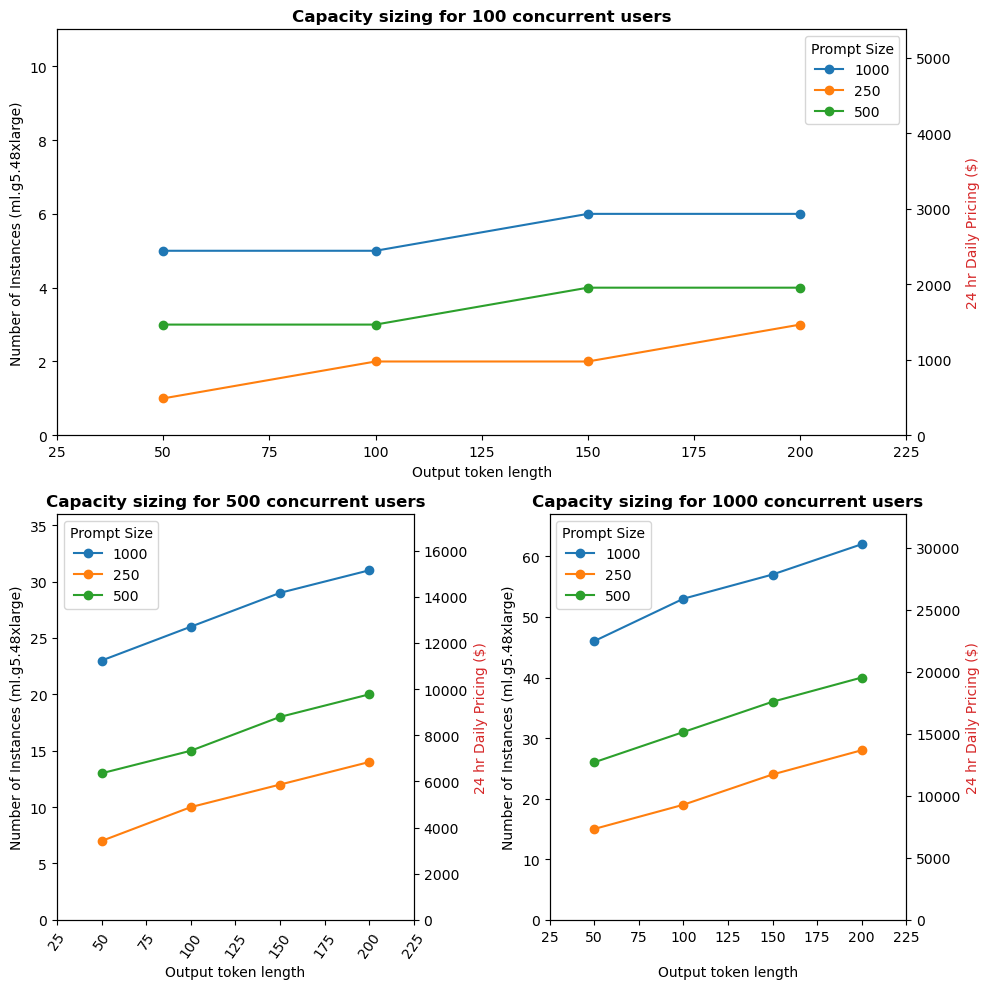

In [332]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.gridspec as gridspec
# plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]
fig = plt.figure(tight_layout=True)
gs = gridspec.GridSpec(2, 2)

# ax = fig.add_subplot(gs[0, :])
ax = fig.add_subplot(gs[0, :])
ax2 = ax.twinx()
df=dataframe_list[0]

for key, group in df.groupby('prompt_size'):  
    ax.plot(group['output_token_length'], group['number_of_instances'], marker='o', label=key)
ax.legend(title='Prompt Size')  
ax.set_xlabel('Output token length')
ax.set_ylabel('Number of Instances (ml.g5.48xlarge)')
plt.title(f'Capacity sizing for {ideal_concurrency[0]} concurrent users',fontweight='bold')
ax.set_xlim(25, 225) 
ax.set_ylim(0, max(df['number_of_instances'])+5) 
color = 'tab:red'
ax2.set_ylabel('24 hr Daily Pricing ($)', color=color) #  per 24 hours
ymin, ymax = ax.get_ylim() 
ax2.set_ylim(0, ymax*pricing_per_instance*24) ## 24 hour daily pricing for each scenario
for i in range(2):
    ax = fig.add_subplot(gs[1, i])
    df=dataframe_list[i+1]
    ax2 = ax.twinx()
    for key, group in df.groupby('prompt_size'):  
        ax.plot(group['output_token_length'], group['number_of_instances'], marker='o', label=key)
        ax.legend(title='Prompt Size')  
        ax.set_xlabel('Output token length')
        ax.set_ylabel('Number of Instances (ml.g5.48xlarge)')
        plt.title(f'Capacity sizing for {ideal_concurrency[i+1]} concurrent users',fontweight='bold')
        ax.set_xlim(25, 225) 
        ax.set_ylim(0, max(df['number_of_instances'])+5) 
        color = 'tab:red'
        ax2.set_ylabel('24 hr Daily Pricing ($)', color=color) #  per 24 hours
        ymin, ymax = ax.get_ylim() 
        ax2.set_ylim(0, ymax*pricing_per_instance*24)
        if i == 0:
                for tick in ax.get_xticklabels():
                    tick.set_rotation(55)
fig.align_labels()  # same as fig.align_xlabels(); fig.align_ylabels()
plt.rcParams["figure.figsize"] = (10,10)
plt.show()

# Content Generation Usage Pattern

In [334]:
# num_parallel_requests = 10  #Number of concurrent users 
results_holder2={}

# Different Content Generation payload patterns
token_length=[250, 500,750,1000]

## Tested concurrent limits for the different token output length under 60s
token_length_concurrency_mapping={250:75,
                                  500:25,
                                  750:10,
                                  1000:2}

prompt="""<<SYS>>You are a great writer<</SYS>>
[INST]Write a novel about Alexander The Great[/INST]"""

for output_token_len in token_length:
    def send_request(prompt):
        time_now=time.time()
        response=predictor.predict({"inputs": prompt,
                          "parameters": {
                "max_new_tokens": output_token_len,
                # "top_p": 0.9,
                # "temperature": 0.6,
                "return_full_text": False,
            }})
        time_later=time.time()
        diff=time_later-time_now
        return diff

    # Create a ThreadPoolExecutor for parallel execution
    with concurrent.futures.ThreadPoolExecutor(max_workers=token_length_concurrency_mapping[output_token_len]) as executor:
        # Submit parallel requests
        futures = [executor.submit(send_request, prompt) for _ in range(token_length_concurrency_mapping[output_token_len])]

        # Wait for all requests to complete
        concurrent.futures.wait(futures)

        # Get the results from completed requests
        results = [future.result() for future in futures]
    results_holder2[output_token_len]=results


In [337]:
max_inference_time=60 # The maximum time threshold for realtime inference in seconds
ideal_concurrency=[100,500,1000] # number of concurrent users that would be making a single call to the endpoint simultaneously in production

dataframe_list=[]
for concurrency in ideal_concurrency:
    data_holder={
             "output_token_length":[],
             "number_of_instances":[],
             }
    for token_length in results_holder2:    
        request_latencies=results_holder2[token_length]
        avg_request_latency=sum(request_latencies)/len(request_latencies) # average time it took to complete the request for a given usage style combination
        normalized_concurrency=max_inference_time/avg_request_latency # normalized request latency time to 60secs which is the threshold timeout for sagemaker realtime inference

        # there number of instances required to meet the ideal concurrent users. This is calculated by
        # dividing the ideal concurrent users by the number of concurreny that would max the sagemaker inference timeout threshold (60s)
        number_of_instances_needed=concurrency/(normalized_concurrency*len(request_latencies)) 
        # print(token_length,avg_request_latency,normalized_concurrency, len(request_latencies),number_of_instances_needed)

        data_holder["output_token_length"].append(token_length)
        data_holder["number_of_instances"].append(round(number_of_instances_needed))        

    df = pd.DataFrame(data_holder)
    pricing_per_instance = 20.36 # Price per hour for the ml.g5.48xlarge instance
    # Calculate total pricing for each row  
    df['Hourly Pricing'] = df['number_of_instances'] * pricing_per_instance
    df['Daily Pricing'] = df['Hourly Pricing'] * 24
    dataframe_list.append(df)

In [338]:
for ids, item in enumerate(dataframe_list):
    print(f'Capacity Sizing for {ideal_concurrency[ids]} concurrent users\n{item}\n')

Capacity Sizing for 100 concurrent users
   output_token_length  number_of_instances  Hourly Pricing  Daily Pricing
0                  250                    1           20.36         488.64
1                  500                    4           81.44        1954.56
2                  750                   10          203.60        4886.40
3                 1000                   48          977.28       23454.72

Capacity Sizing for 500 concurrent users
   output_token_length  number_of_instances  Hourly Pricing  Daily Pricing
0                  250                    7          142.52        3420.48
1                  500                   18          366.48        8795.52
2                  750                   48          977.28       23454.72
3                 1000                  238         4845.68      116296.32

Capacity Sizing for 1000 concurrent users
   output_token_length  number_of_instances  Hourly Pricing  Daily Pricing
0                  250                   13      

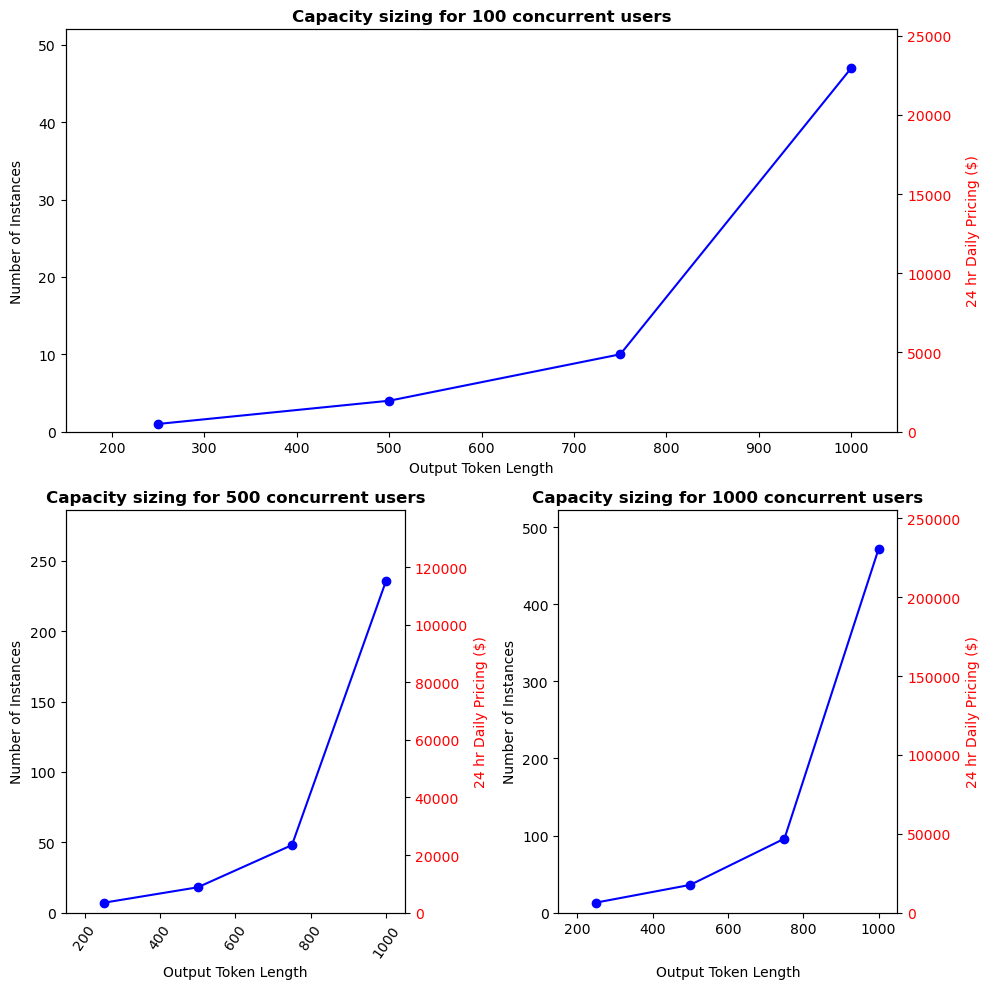

In [302]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.gridspec as gridspec
# plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]
fig = plt.figure(tight_layout=True)
gs = gridspec.GridSpec(2, 2)

ax = fig.add_subplot(gs[0, :])
ax2 = ax.twinx()
df=dataframe_list[0]
ax.plot(df.output_token_length, df.number_of_instances, 'bo-')
ax.set_xlabel('Output Token Length')
ax.set_ylabel('Number of Instances')
ax.set_ylim(0, max(df['number_of_instances'])+50) 
ax.set_xlim(150, max(df.output_token_length)+50) 
ax2.tick_params(axis='y', labelcolor='r')
ax2.set_ylabel('24 hr Daily Pricing ($)', color='r')
ymin, ymax = ax.get_ylim() 
ax2.set_ylim(0, ymax*pricing_per_instance*24)
plt.title(f'Capacity sizing for {ideal_concurrency[0]} concurrent users',fontweight='bold')
for i in range(2):
    ax = fig.add_subplot(gs[1, i])
    df=dataframe_list[i+1]
    ax2 = ax.twinx()
    ax.plot(df.output_token_length, df.number_of_instances, 'bo-')
    ax.set_xlabel('Output Token Length')
    ax.set_ylabel('Number of Instances')
    ax.set_ylim(0, max(df['number_of_instances'])+50) 
    ax.set_xlim(150, max(df.output_token_length)+50) 
    ax2.tick_params(axis='y', labelcolor='r')
    ax2.set_ylabel('24 hr Daily Pricing ($)', color='r')
    ymin, ymax = ax.get_ylim() 
    ax2.set_ylim(0, ymax*pricing_per_instance*24)
    plt.title(f'Capacity sizing for {ideal_concurrency[i+1]} concurrent users',fontweight='bold')
    if i == 0:
        for tick in ax.get_xticklabels():
            tick.set_rotation(55)
fig.align_labels()  # same as fig.align_xlabels(); fig.align_ylabels()
plt.rcParams["figure.figsize"] = (10,10)
plt.show()


# Code Documentation

In [8]:
## Initialize sagemaker endpoint
from sagemaker.predictor import Predictor
from sagemaker.serializers import JSONSerializer
from sagemaker.deserializers import JSONDeserializer
predictor=Predictor(endpoint_name="jumpstart-dft-llama-codellama-34b-instructyuy",#endpoint_name_code,
                    serializer=JSONSerializer(),                    
    deserializer=JSONDeserializer(),
                   )

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


In [29]:
prompt="""<<SYS>>You are an expert python programmer. 

Here is a python script:

DYNAMODB      = boto3.resource('dynamodb')
S3            = boto3.client('s3', region_name=REGION)
TEXTRACT      = boto3.client('textract', region_name=REGION)
KENDRA        = boto3.client('kendra', region_name=REGION)
SAGEMAKER     = boto3.client('sagemaker-runtime', region_name=REGION)
BEDROCK = boto3.client(service_name='bedrock-runtime',region_name='us-east-1') 
COMPREHEND=boto3.client("comprehend")

def query_index(query):  
    response = KENDRA.retrieve(
    IndexId=KENDRA_ID,
    QueryText=query,
    )
    return response
    
def kendra_index(doc_name):
    import time
    response=KENDRA.list_data_sources(IndexId=KENDRA_ID)['SummaryItems']
    data_sources=[x["Name"] for x in response if KENDRA_S3_DATA_SOURCE_NAME in x["Name"]]
    if data_sources: # Check if s3 data source already exist and sync files
        data_source_id=[x["Id"] for x in response if KENDRA_S3_DATA_SOURCE_NAME in x["Name"] ][0]
        sync_response = KENDRA.start_data_source_sync_job(
        Id = data_source_id,
        IndexId =KENDRA_ID
        )    
        status=True
        while status:
            jobs = KENDRA.list_data_source_sync_jobs(
                Id = data_source_id,
                IndexId = KENDRA_ID
            )
            # For this example, there should be one job        
            try:
                status = jobs["History"][0]["Status"]
                st.write(" Syncing data source. Status: "+status)
                if status != "SYNCING":
                    status=False
                time.sleep(2)
            except:
                time.sleep(2)
    else: # Create a Kendra s3 data source and sync files
        
        index_id=KENDRA_ID
        response = KENDRA.create_data_source(
            Name=KENDRA_S3_DATA_SOURCE_NAME,
            IndexId=index_id,
            Type='S3',
            Configuration={
                'S3Configuration': {
                    'BucketName': BUCKET,
                    'InclusionPrefixes': [
                        f"{PREFIX}/",
                    ],            
                },
            },     
            RoleArn=KENDRA_ROLE, 
            ClientToken=doc_name,                
        )    
        data_source_id=response['Id']
        import time
        status=True
        while status:
            # Get the details of the data source, such as the status
            data_source_description = KENDRA.describe_data_source(
                Id = data_source_id,
                IndexId = index_id
            )
            # If status is not CREATING, then quit
            status = data_source_description["Status"]
            st.write(" Creating data source. Status: "+status)
            time.sleep(2)
            if status != "CREATING":
                status=False            
        sync_response = KENDRA.start_data_source_sync_job(
            Id = data_source_id,
            IndexId = index_id
        )    
        status=True
        while status:
            jobs = KENDRA.list_data_source_sync_jobs(
                Id = data_source_id,
                IndexId = index_id
            )
                   
            try:
                status = jobs["History"][0]["Status"]
                st.write(" Syncing data source. Status: "+status)
                if status != "SYNCING":
                    status=False
                time.sleep(2)
            except:
                time.sleep(2)<</SYS>>
                
[INST]document each line of the python code[/INST]"""

In [28]:
tok=tokenizer.encode(prompt, return_tensors="pt")[0]
len(tok)

501

In [58]:
# num_parallel_requests = 10  #Number of concurrent users 
results_holder3={}

# Different Content Generation payload patterns
token_length=[100, 200, 500,750,1000]

## Tested concurrent limits for the different token output length under 60s
token_length_concurrency_mapping={100:35,
                                  200:30,
                                  500:20,
                                  750:14,
                                 1000:8}

for output_token_len in token_length:
    def send_request(prompt):
        time_now=time.time()
        response=predictor.predict({"inputs": prompt,
                          "parameters": {
                "max_new_tokens": output_token_len,
                # "top_p": 0.9,
                # "temperature": 0.6,
                "return_full_text": False,
            }})
        time_later=time.time()
        diff=time_later-time_now
        return diff

    # Create a ThreadPoolExecutor for parallel execution
    with concurrent.futures.ThreadPoolExecutor(max_workers=token_length_concurrency_mapping[output_token_len]) as executor:
        # Submit parallel requests
        futures = [executor.submit(send_request, prompt) for _ in range(token_length_concurrency_mapping[output_token_len])]

        # Wait for all requests to complete
        concurrent.futures.wait(futures)

        # Get the results from completed requests
        results = [future.result() for future in futures]
    results_holder3[output_token_len]=results


In [71]:
max_inference_time=60 # The maximum time threshold for realtime inference in seconds
ideal_concurrency=[100,500,1000] # number of concurrent users that would be making a single call to the endpoint simultaneously in production
prompt_size=tokenizer.encode(prompt, return_tensors="pt")[0]

dataframe_list=[]
for concurrency in ideal_concurrency:
    data_holder={
             "output_token_length":[],
             "number_of_instances":[],
             }
    for token_length in results_holder3:    
        request_latencies=results_holder3[token_length]
        avg_request_latency=sum(request_latencies)/len(request_latencies) # average time it took to complete the request for a given usage style combination
        normalized_concurrency=max_inference_time/avg_request_latency # normalized request latency time to 60secs which is the threshold timeout for sagemaker realtime inference

        # there number of instances required to meet the ideal concurrent users. This is calculated by
        # dividing the ideal concurrent users by the number of concurreny that would max the sagemaker inference timeout threshold (60s)
        number_of_instances_needed=concurrency/(normalized_concurrency*len(request_latencies)) 
        # print(token_length,avg_request_latency,normalized_concurrency, len(request_latencies),number_of_instances_needed)

        data_holder["output_token_length"].append(token_length)
        data_holder["number_of_instances"].append(round(number_of_instances_needed))        

    df = pd.DataFrame(data_holder)
    pricing_per_instance = 20.36 # Price per hour for the ml.g5.48xlarge instance
    # Calculate total pricing for each row  
    df['Hourly Pricing'] = df['number_of_instances'] * pricing_per_instance
    df['Daily Pricing'] = df['Hourly Pricing'] * 24 
    dataframe_list.append(df)

In [74]:
for ids, item in enumerate(dataframe_list):
    print(f'Capacity Sizing for {ideal_concurrency[ids]} concurrent users with {len(prompt_size)} prompt size\n\n{item}\n')

Capacity Sizing for 100 concurrent users with 1045 prompt size

   output_token_length  number_of_instances  Hourly Pricing  Daily Pricing
0                  100                    3           61.08        1465.92
1                  200                    3           61.08        1465.92
2                  500                    5          101.80        2443.20
3                  750                    7          142.52        3420.48
4                 1000                   12          244.32        5863.68

Capacity Sizing for 500 concurrent users with 1045 prompt size

   output_token_length  number_of_instances  Hourly Pricing  Daily Pricing
0                  100                   14          285.04        6840.96
1                  200                   16          325.76        7818.24
2                  500                   24          488.64       11727.36
3                  750                   35          712.60       17102.40
4                 1000                   58   

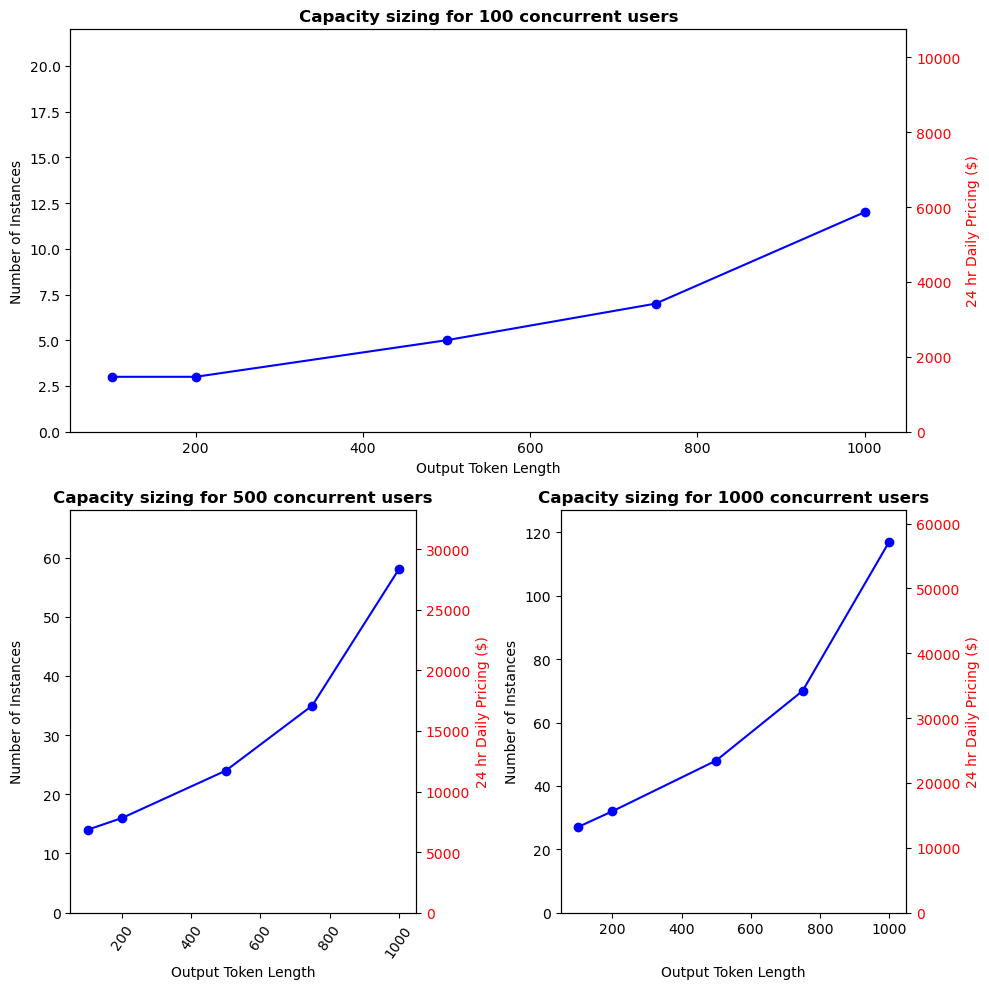

In [78]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.gridspec as gridspec
# plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]
fig = plt.figure(tight_layout=True)
gs = gridspec.GridSpec(2, 2)

ax = fig.add_subplot(gs[0, :])
ax2 = ax.twinx()
df=dataframe_list[0]
ax.plot(df.output_token_length, df.number_of_instances, 'bo-')
ax.set_xlabel('Output Token Length')
ax.set_ylabel('Number of Instances')
ax.set_ylim(0, max(df['number_of_instances'])+10) 
ax.set_xlim(50, max(df.output_token_length)+50) 
ax2.tick_params(axis='y', labelcolor='r')
ax2.set_ylabel('24 hr Daily Pricing ($)', color='r')
ymin, ymax = ax.get_ylim() 
ax2.set_ylim(0, ymax*pricing_per_instance*24)
plt.title(f'Capacity sizing for {ideal_concurrency[0]} concurrent users',fontweight='bold')
for i in range(2):
    ax = fig.add_subplot(gs[1, i])
    df=dataframe_list[i+1]
    ax2 = ax.twinx()
    ax.plot(df.output_token_length, df.number_of_instances, 'bo-')
    ax.set_xlabel('Output Token Length')
    ax.set_ylabel('Number of Instances')
    ax.set_ylim(0, max(df['number_of_instances'])+10) 
    ax.set_xlim(50, max(df.output_token_length)+50) 
    ax2.tick_params(axis='y', labelcolor='r')
    ax2.set_ylabel('24 hr Daily Pricing ($)', color='r')
    ymin, ymax = ax.get_ylim() 
    ax2.set_ylim(0, ymax*pricing_per_instance*24)
    plt.title(f'Capacity sizing for {ideal_concurrency[i+1]} concurrent users',fontweight='bold')
    if i == 0:
        for tick in ax.get_xticklabels():
            tick.set_rotation(55)
fig.align_labels()  # same as fig.align_xlabels(); fig.align_ylabels()
plt.rcParams["figure.figsize"] = (10,10)
plt.show()


# CODE GENERATION

In [91]:
prompt="""<<SYS>>You are an expert python programmer.</SYS>>
                
[INST]write a python code to do the following:
1. Create an Amazon opensearch domain.
2. Create 5 indexes in the domain
3. A Amazon textract job to analyze multiple page pdfs in s3
4. Retrieve the response from Textract and save the extracted text to a text file
5. Chunk the text file to no more than 300 words.
6 Index each chuck file into the open search index[/INST]"""

In [100]:
%%time
res=predictor.predict({"inputs": prompt,
                      "parameters": {
            "max_new_tokens": 1500,
            # "top_p": 0.9,
            # "temperature": 0.6,
            "return_full_text": False,
        }})
# print(res[0]['generated_text'])

CPU times: user 5.05 ms, sys: 1.79 ms, total: 6.84 ms
Wall time: 48.4 s


In [101]:
tok=tokenizer.encode(res[0]['generated_text'], return_tensors="pt")[0]
len(tok)

1501

In [116]:
# num_parallel_requests = 10  #Number of concurrent users 
results_holder4={}

# Different Content Generation payload patterns
token_length=[250,500,1000,1500]

## Tested concurrent limits for the different token output length under 60s
token_length_concurrency_mapping={250:110,
                                  500:60,
                                  1000:20,
                                  1500:6 }

for output_token_len in token_length:
    def send_request(prompt):
        time_now=time.time()
        response=predictor.predict({"inputs": prompt,
                          "parameters": {
                "max_new_tokens": output_token_len,
                # "top_p": 0.9,
                # "temperature": 0.6,
                "return_full_text": False,
            }})
        time_later=time.time()
        diff=time_later-time_now
        return diff

    # Create a ThreadPoolExecutor for parallel execution
    with concurrent.futures.ThreadPoolExecutor(max_workers=token_length_concurrency_mapping[output_token_len]) as executor:
        # Submit parallel requests
        futures = [executor.submit(send_request, prompt) for _ in range(token_length_concurrency_mapping[output_token_len])]

        # Wait for all requests to complete
        concurrent.futures.wait(futures)

        # Get the results from completed requests
        results = [future.result() for future in futures]
    results_holder4[output_token_len]=results


In [118]:
max_inference_time=60 # The maximum time threshold for realtime inference in seconds
ideal_concurrency=[100,500,1000] # number of concurrent users that would be making a single call to the endpoint simultaneously in production
prompt_size=tokenizer.encode(prompt, return_tensors="pt")[0]

dataframe_list=[]
for concurrency in ideal_concurrency:
    data_holder={
             "output_token_length":[],
             "number_of_instances":[],
             }
    for token_length in results_holder4:    
        request_latencies=results_holder4[token_length]
        avg_request_latency=sum(request_latencies)/len(request_latencies) # average time it took to complete the request for a given usage style combination
        normalized_concurrency=max_inference_time/avg_request_latency # normalized request latency time to 60secs which is the threshold timeout for sagemaker realtime inference

        # there number of instances required to meet the ideal concurrent users. This is calculated by
        # dividing the ideal concurrent users by the number of concurreny that would max the sagemaker inference timeout threshold (60s)
        number_of_instances_needed=concurrency/(normalized_concurrency*len(request_latencies)) 
        # print(token_length,avg_request_latency,normalized_concurrency, len(request_latencies),number_of_instances_needed)

        data_holder["output_token_length"].append(token_length)
        data_holder["number_of_instances"].append(round(number_of_instances_needed))        

    df = pd.DataFrame(data_holder)
    pricing_per_instance = 20.36 # Price per hour for the ml.g5.48xlarge instance
    # Calculate total pricing for each row  
    df['Hourly Pricing'] = df['number_of_instances'] * pricing_per_instance
    df['Daily Pricing'] = df['Hourly Pricing'] * 24 
    dataframe_list.append(df)

In [119]:
for ids, item in enumerate(dataframe_list):
    print(f'Capacity Sizing for {ideal_concurrency[ids]} concurrent users with {len(prompt_size)} prompt size\n\n{item}\n')

Capacity Sizing for 100 concurrent users with 121 prompt size

   output_token_length  number_of_instances  Hourly Pricing  Daily Pricing
0                  250                    1           20.36         488.64
1                  500                    2           40.72         977.28
2                 1000                    5          101.80        2443.20
3                 1500                   16          325.76        7818.24

Capacity Sizing for 500 concurrent users with 121 prompt size

   output_token_length  number_of_instances  Hourly Pricing  Daily Pricing
0                  250                    4           81.44        1954.56
1                  500                    8          162.88        3909.12
2                 1000                   25          509.00       12216.00
3                 1500                   82         1669.52       40068.48

Capacity Sizing for 1000 concurrent users with 121 prompt size

   output_token_length  number_of_instances  Hourly Pricin

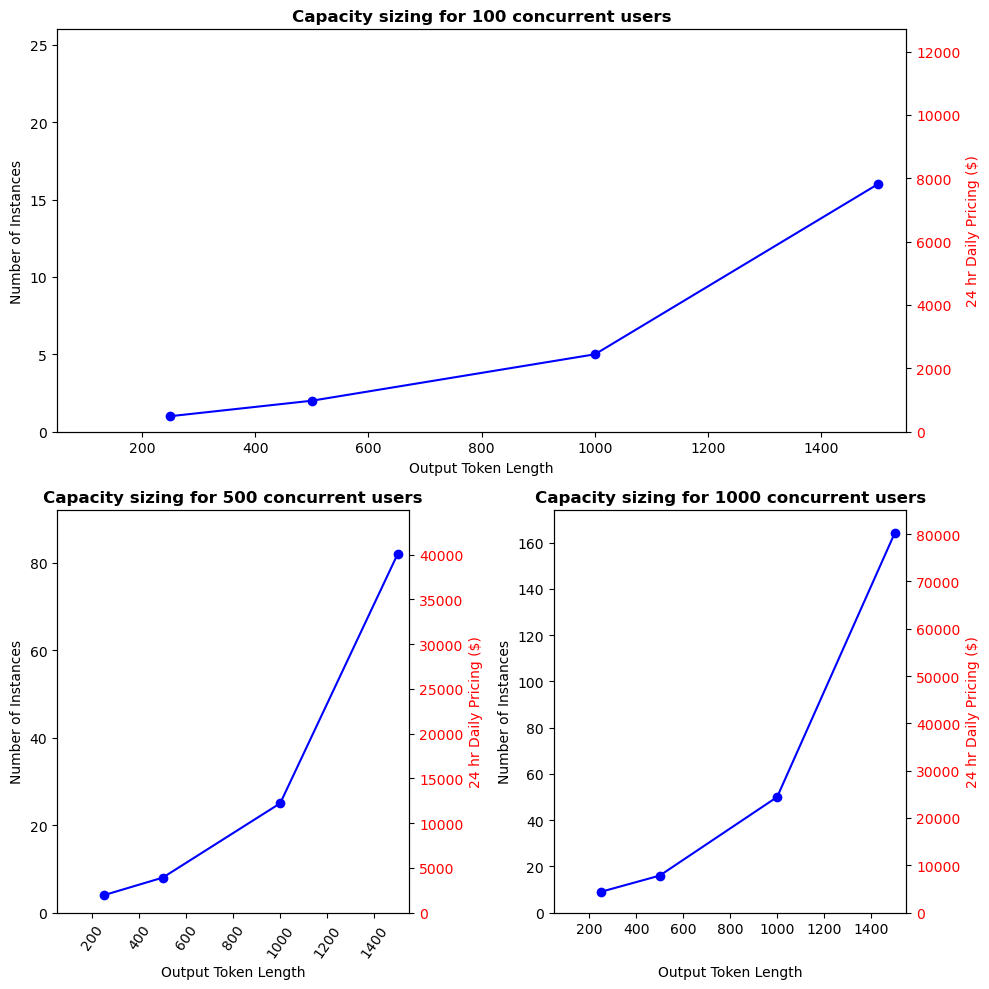

In [120]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.gridspec as gridspec
# plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]
fig = plt.figure(tight_layout=True)
gs = gridspec.GridSpec(2, 2)

ax = fig.add_subplot(gs[0, :])
ax2 = ax.twinx()
df=dataframe_list[0]
ax.plot(df.output_token_length, df.number_of_instances, 'bo-')
ax.set_xlabel('Output Token Length')
ax.set_ylabel('Number of Instances')
ax.set_ylim(0, max(df['number_of_instances'])+10) 
ax.set_xlim(50, max(df.output_token_length)+50) 
ax2.tick_params(axis='y', labelcolor='r')
ax2.set_ylabel('24 hr Daily Pricing ($)', color='r')
ymin, ymax = ax.get_ylim() 
ax2.set_ylim(0, ymax*pricing_per_instance*24)
plt.title(f'Capacity sizing for {ideal_concurrency[0]} concurrent users',fontweight='bold')
for i in range(2):
    ax = fig.add_subplot(gs[1, i])
    df=dataframe_list[i+1]
    ax2 = ax.twinx()
    ax.plot(df.output_token_length, df.number_of_instances, 'bo-')
    ax.set_xlabel('Output Token Length')
    ax.set_ylabel('Number of Instances')
    ax.set_ylim(0, max(df['number_of_instances'])+10) 
    ax.set_xlim(50, max(df.output_token_length)+50) 
    ax2.tick_params(axis='y', labelcolor='r')
    ax2.set_ylabel('24 hr Daily Pricing ($)', color='r')
    ymin, ymax = ax.get_ylim() 
    ax2.set_ylim(0, ymax*pricing_per_instance*24)
    plt.title(f'Capacity sizing for {ideal_concurrency[i+1]} concurrent users',fontweight='bold')
    if i == 0:
        for tick in ax.get_xticklabels():
            tick.set_rotation(55)
fig.align_labels()  # same as fig.align_xlabels(); fig.align_ylabels()
plt.rcParams["figure.figsize"] = (10,10)
plt.show()


In [160]:
import boto3

def delete_endpoint(endpoint_name):
    sm_client = boto3.client('sagemaker')
    try:
        # Get the endpoint configuration name first
        response = sm_client.describe_endpoint(EndpointName=endpoint_name)
        endpoint_config_name = response['EndpointConfigName']

        # Delete the endpoint
        # sm_client.delete_endpoint(EndpointName=endpoint_name)
        print(f"Endpoint {endpoint_name} deleted successfully.")

        # Delete the endpoint configuration
        sm_client.delete_endpoint_config(EndpointConfigName=endpoint_config_name)
        print(f"Endpoint configuration {endpoint_config_name} deleted successfully.")
    except Exception as e:
        print(f"Error deleting endpoint {endpoint_name} and its configuration: {str(e)}")

# Assuming 'config_file' is a list of dictionaries with 'endpoint' and 'instance' keys
delete_endpoint(endpoint_name)
delete_endpoint(endpoint_name_code)

Endpoint Llama2-70b-gptq-6387348 deleted successfully.
Endpoint configuration Llama2-70b-gptq-6387348 deleted successfully.
